## Comparación con otras bibliotecas (PyMC, NumPyro, TFP)

Aparte de la compatibilidad nativa con NumPy, JAX ofrece alto nivel de compatibilidad con otras bibliotecas para inferencia Bayesiana. Por ejemplo, si es especificamos un modelo en un lenguaje de programación probabilistica como PyMC podemos obtener resultados similares definiendo nuestras propias funciones de verosimilitud.  

In [106]:
import pymc as pm
import numpy as np

observed, test_point = 5.0, 2.5 

PyMC define un modelo mediante un ContextManager para el cual se declaran las variables de la distribución apriori de un parámetro $p(\theta)$ y la verosimilitud de los datos observados $p(y \vert \theta)$. Por lo tanto, podemos calcular el logaritmo de la distribución posterior (no normalizada) como:

\begin{align}
\operatorname{log} p(\theta \vert y) \propto \operatorname{log} p(y \vert \theta)+\operatorname{log} p(\theta) 
\end{align}

De esta misma forma, podemos calcular la derivada de esta distribución con respecto a $\theta$

[Bayesian Modeling and Computacion. Chapter 10](https://bayesiancomputationbook.com/notebooks/chp_10.html#code-10-2)

In [107]:
with pm.Model() as model:
    z = pm.Normal("z", 0., 5.)
    x = pm.Normal("x", mu=z, sigma=1., observed=observed)

func = model.logp_dlogp_function()
func.set_extra_values({})
ll,gr=func(np.array([test_point]))

print('log-posterior : {0:.2f}, gradiente : {1:.2f}'.format(ll,gr[0]))

log-posterior : -6.70, gradiente : 2.40


JAX permite definir modelos probabilísticos utilizando una interfaz tipo NumPy. Esto permite expresar funciones de verosimilitud y probabilidades a priori complejas. Al mismo tiempo, la diferenciación automática de JAX y la compilación JIT facilitan un muestreo eficiente a partir de la distribución posterior.

In [108]:
import distrax
from jax import grad

def log_likelihood(test_point):
    log_prior=distrax.Normal(0.,5.).log_prob(test_point)
    log_like=distrax.Normal(test_point,1.).log_prob(observed)
    return log_prior+log_like

dlog_p = grad(log_likelihood)

print('log-posterior : {0:.2f}, gradiente : {1:.2f}'.format(log_likelihood(test_point),
                                                            dlog_p(test_point)))

log-posterior : -6.70, gradiente : 2.40


Supongamos que queremos simular una cadena de Markov para $\theta$. 

In [124]:
from jax import lax

def proposal(prev_val, key):
    new = prev_val + distrax.Normal(0.,1.).sample(seed=key)
    return new, prev_val

def sample(key, num_steps):
    multiple_keys = jax.random.split(key, num_steps)
    final, draws = lax.scan(proposal, test_point, multiple_keys)
    return final, draws

initial_key=jax.random.PRNGKey(0)
final, draws = sample(initial_key,1_000)

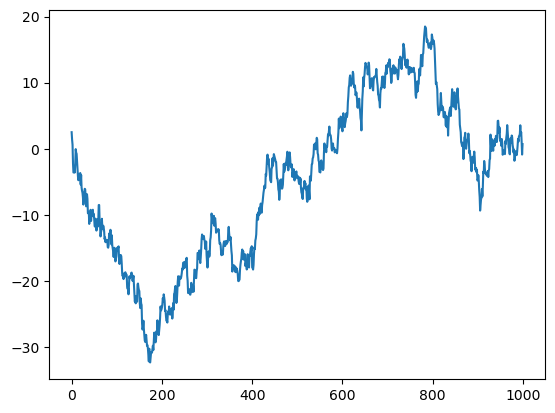

In [125]:
import matplotlib.pyplot as plt

plt.plot(draws)

La función de verosimilitud posterior *log_likelihood* fue definida solamente para un punto de inicio, por lo tanto si queremos evaluar la verosimilitud de todos las muestras podemos vectorizar la función anteriormente definida.

In [126]:

from jax import vmap

%time log_posterior=vmap(log_likelihood)(draws)

CPU times: user 8.26 ms, sys: 4.04 ms, total: 12.3 ms
Wall time: 10.7 ms


JIT significa compilación justo a tiempo (Just In Time Compilation), es una característica crucial de JAX que desempeña un papel importante en la aceleración de la inferencia bayesiana.  

In [112]:
from jax import jit

jitted_log_likelihood=jit(log_likelihood)

%time jitted_log_posterior=vmap(jitted_log_likelihood)(draws)

CPU times: user 27.3 ms, sys: 3.98 ms, total: 31.2 ms
Wall time: 31.6 ms


In [127]:
%time jitted_log_posterior=vmap(jitted_log_likelihood)(draws)

CPU times: user 2.53 ms, sys: 1.05 ms, total: 3.58 ms
Wall time: 2.93 ms


Ahora, supogamos que queremos implementar un método de muestreo usando aceptación-rechazo. Aceptamos una muestra $\theta_{i+1}$ de acuerdo al criterio:

$p_a (\theta_{i + 1} \mid \theta_i) = \min \left (1, \frac{p(\theta_{i + 1}) \;
q(\theta_i \mid \theta_{i + 1})} {p(\theta_i) \; q (\theta_{i + 1} \mid \theta_i)} \right)$

In [141]:
def mh_proposal(prev_val, key):
    key_proposal,key_mh=jax.random.split(key)
    new = prev_val + distrax.Normal(0.,1.).sample(seed=key_proposal)
    log_ratio=jitted_log_likelihood(new)-jitted_log_likelihood(prev_val)
    log_uniform=jnp.log(distrax.Uniform(0.,1.).sample(seed=key_mh))
    accept=log_ratio>log_uniform
    new=jnp.where(accept, new, prev_val)
    return new, prev_val

def metropolis_hastings(key, num_steps):
    multiple_keys = jax.random.split(key, num_steps)
    final, draws = lax.scan(mh_proposal, test_point, multiple_keys)
    return final, draws

single_chain_final, single_chain_draws = metropolis_hastings(initial_key,1_000)

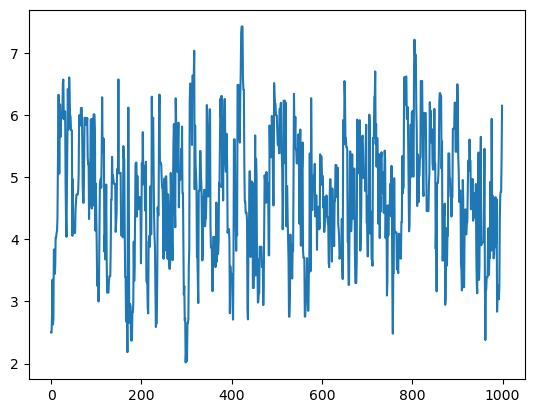

In [142]:
plt.plot(single_chain_draws)

In [143]:
multiple_keys=jax.random.split(initial_key,100)

multiple_chain_final,multiple_chain_draws=vmap(metropolis_hastings,(0,None))(multiple_keys,1_000)

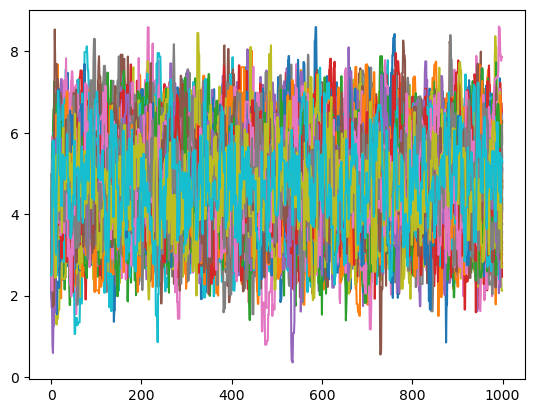

In [144]:
plt.plot(multiple_chain_draws.T);